In [0]:
#!kill -9 -1
!pip install tensorflow==1.9.0
!pip install keras
!pip install dropbox

    100% |████████████████████████████████| 51.1MB 870kB/s 
    100% |████████████████████████████████| 3.3MB 6.5MB/s 
    100% |████████████████████████████████| 573kB 16.9MB/s 
magenta 0.3.19 has requirement tensorflow>=1.12.0, but you'll have tensorflow 1.9.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
  Found existing installation: setuptools 40.8.0
    Uninstalling setuptools-40.8.0:
      Successfully uninstalled setuptools-40.8.0
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1


    100% |████████████████████████████████| 512kB 21.2MB/s 


In [0]:
################################################################


data_url = "https://dl.dropboxusercontent.com/s/m7ac0fypmcaxi3e/data2.csv"

prate_url = "https://dl.dropboxusercontent.com/s/0mzxabpws5py869/prate.csv"

shum_url = "https://dl.dropboxusercontent.com/s/l0ey0keumi68sf3/shum.csv"


tmax_url = "https://dl.dropboxusercontent.com/s/m5ij9fysi4mxpy8/tmax.csv"

tmin_url = "https://dl.dropboxusercontent.com/s/y5mjcqbjtv6dfd7/tmin.csv"

tmp_url = "https://dl.dropboxusercontent.com/s/jlbj1bzzfywd93s/tmp.csv"

uwind_url = "https://dl.dropboxusercontent.com/s/sfwnqwfqpsdsewr/uwind.csv"

vwind_url = "https://dl.dropboxusercontent.com/s/74w4ich5ldaajis/vwind.csv"

dswrf_url = "https://dl.dropboxusercontent.com/s/mzy10j72ctcu51y/dswrf.csv"

evap_url = "https://dl.dropboxusercontent.com/s/ent7j3bw676slfc/evap.csv"

cloud_url ="https://dl.dropboxusercontent.com/s/tdi003zjkkst2jf/cloud_cover.csv"


# coding: utf-8

# In[1]:


# LSTM for international airline passengers problem with regression framing
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv, DataFrame
import math
from keras import backend as K
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dense, Dropout, TimeDistributed, Embedding
from keras.layers import LSTM
from keras.constraints import nonneg
from keras import backend
from keras.regularizers import L1L2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import itertools as itr
#import h5py
import tensorflow as tf
####################################################################################
# In[25]:


refine = 0
look_back = 4
n_seq = 4
batch_size = 8
epochs = 500
timesteps = 4

np.random.seed(7)
names = {'inf':0, 'shum':1, 'evap':2, 'tmp':3, 'tmin':4, 'tmax':5, 'cloud':6, 'wind':7, 'dswrf':8, 'prate':9}
param_list = ['shum', 'evap', 'tmp', 'tmin', 'tmax', 'cloud', 'wind', 'dswrf', 'prate']



# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, n_seq=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-n_seq):
		a = dataset[i:(i+look_back), :]# 0 is removed
		dataX.append(a)
		dataY.append(dataset[(i + look_back):(i + look_back + n_seq), 0])
	return np.array(dataX), np.array(dataY)

# function for reshaping data
def weight_func(weight_mat):
    weight_mat[:,21] = 0
    weight_mat[:,24] = 0
    weight_mat[:,25] = 0
    weight_mat[:,30] = 0
    weight_mat[:,32] = 0
    weight_mat[:,33] = 0
    weight_mat[:,39] = 0
    weight_mat[:,47] = 0
    weight_mat[:,55] = 0
    return weight_mat

def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))


def reshape_data(dataset):
    output = np.zeros((430, 1))
    for i in range(430):
        matOriginal = np.reshape(dataset[i], (10, 8))
        output[i] = matOriginal[0:10,0:8].mean()
    return output


# load the dataset
#input_cols = range(2)
def load_data():
    dataframe1 = read_csv(data_url, usecols=[3], header=None, engine='python', skipfooter=0)
    dataframe2 = read_csv(data_url, usecols=[4], header=None, engine='python', skipfooter=0)
    dataset = dataframe1.values

    dataframe_shum = read_csv(shum_url, usecols=range(80), header=None, engine='python', skipfooter=0)
    dataset_shum = np.reshape(dataframe_shum.mean(axis=1).values, (430,1))
    #dataset_shum = reshape_data(weight_func(dataframe_shum.values))


    dataframe_tmp = read_csv(tmp_url, usecols=range(80), header=None, engine='python', skipfooter=0)
    dataset_tmp = np.reshape(dataframe_tmp.mean(axis=1).values, (430,1))
    #dataset_tmp = reshape_data(dataframe_tmp.values)

    dataframe_dswrf = read_csv(dswrf_url, usecols=range(80), header=None, engine='python', skipfooter=0)
    dataset_dswrf = np.reshape(dataframe_dswrf.mean(axis=1).values, (430,1))
    #dataset_dswrf = reshape_data(dataframe_dswrf.values)

    dataframe_evap = read_csv(evap_url, usecols=range(80), header=None, engine='python', skipfooter=0)
    dataset_evap = np.reshape(dataframe_evap.mean(axis=1).values, (430,1))
    #dataset_evap = reshape_data(dataframe_evap.values)

    dataframe_prate = read_csv(prate_url, usecols=range(80), header=None, engine='python', skipfooter=0)
    dataset_prate = np.reshape(dataframe_prate.mean(axis=1).values, (430,1))
    #dataset_prate = reshape_data(weight_func(dataframe_prate.values))

    dataframe_cloud = read_csv(cloud_url, usecols=range(80), header=None, engine='python', skipfooter=0)
    dataset_cloud = np.reshape(dataframe_cloud.mean(axis=1).values, (430,1))
    #dataset_cloud = reshape_data(dataframe_cloud.values)

    dataframe_skt = read_csv(tmp_url, usecols=range(80), header=None, engine='python', skipfooter=0)
    dataset_skt = np.reshape(dataframe_skt.mean(axis=1).values, (430,1))
    #dataset_skt = reshape_data(dataframe_skt.values)

    dataframe_tmin = read_csv(tmin_url, usecols=range(80), header=None, engine='python', skipfooter=0)
    dataset_tmin = np.reshape(dataframe_tmin.mean(axis=1).values, (430,1))
    #dataset_tmin = reshape_data(dataframe_tmin.values)

    dataframe_tmax = read_csv(tmax_url, usecols=range(80), header=None, engine='python', skipfooter=0)
    dataset_tmax = np.reshape(dataframe_tmax.mean(axis=1).values, (430,1))
    #dataset_tmax = reshape_data(dataframe_tmax.values)

    dataframe_uwind = read_csv(uwind_url, usecols=range(80), header=None, engine='python', skipfooter=0)
    dataset_uwind = np.reshape(dataframe_uwind.mean(axis=1).values, (430,1))
    #dataset_uwind = reshape_data(dataframe_uwind.values)

    dataframe_vwind = read_csv(vwind_url, usecols=range(80), header=None, engine='python', skipfooter=0)
    dataset_vwind = np.reshape(dataframe_vwind.mean(axis=1).values, (430,1))
    #dataset_vwind = reshape_data(dataframe_vwind.values)
    
    dataset_wind = np.sqrt(np.power(dataset_vwind[:],2)+np.power(dataset_uwind[:],2))
    
    #dataset_time = np.reshape(np.array([x for x in range(430)]) % 53, (430,1))

    output_dataset = np.concatenate((dataset, dataset_shum, dataset_evap, dataset_tmp, dataset_tmin, dataset_tmax,
                                        dataset_cloud, dataset_wind, dataset_dswrf, dataset_prate), axis=1)
    return output_dataset


def permute_list(param_list, max_permute):    
    output_list = list()
    for i in range(max_permute + 1):
        a = itr.combinations(param_list, i)
        output_list = output_list + [x for x in a]
    return [['inf'] + list(x) for x in output_list]

# create and fit the LSTM network
def build_model(input_size):
    regulizers = [L1L2(l1=0.0, l2=0.0)]
    model = Sequential()
    model.add(LSTM(32, input_shape=(look_back, input_size)))
    #model.add(Dropout(0.2))
    #model.add(LSTM(10, input_shape=(8, look_back, input_size)))
    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.2))

    #model.add(Dense(n_seq))
    model.add(Dense(n_seq, W_constraint=nonneg()))
    model.compile(loss='mean_squared_error', optimizer='adam')#, metrics=['mse', 'mae', rmse])
    return model

Using TensorFlow backend.


In [0]:
#@title
###################################################################################
#with tf.device('/GPU:0'):
total_dataset = load_data()
perm_list = permute_list(param_list, 3)

final_result = np.zeros((len(perm_list), 77, n_seq))


i_start = 0
for param in perm_list:
    print('Running for Permutation ... ', i_start)
    indx = [names[x] for x in param]
    dataset = total_dataset[:,indx]
#dataset = np.concatenate((dataset, dataset, dataset_shum, dataset_evap, dataset_tmp, dataset_uwind), axis=1)
#dataset = np.concatenate((dataset, dataset_prate), axis=1)

    input_size = len(param)
    # split into train and test sets
    train_size = int(len(dataset) * 0.80)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    train = scaler.fit_transform(train)
    test = scaler.transform(test)

    trainX, trainY = create_dataset(train, look_back, n_seq)
    testX, testY = create_dataset(test, look_back, n_seq)


    if refine == 1:
        for j in range(input_size - 1):
            for i in range(len(trainX)):
                trainX[i,:][0:2,j+1] = trainX[i,:][0:2,j+1].mean()
                trainX[i,:][2:4,j+1] = trainX[i,:][2:4,j+1].mean()
                #trainX[i,:][3,j+1] = trainX[i,:][3,j+1] - trainX[i,:][2,j+1]

            for i in range(len(testX)):
                testX[i,:][0:2,j+1] = testX[i][0:2,j+1].mean()
                testX[i,:][2:4,j+1] = testX[i][2:4,j+1].mean()
                #testX[i,:][3,j+1] = testX[i,:][3,j+1] - testX[i,:][2,j+1]

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], look_back, input_size))
    testX = np.reshape(testX, (testX.shape[0], look_back, input_size))

    weights_cat = np.ones(trainX.shape[0])
    l = 0
    for sample in trainX:
        if sample[:,0].mean() < .01:
            weights_cat[l] = 1.5
        l = l + 1;

    model = build_model(input_size)


    history = model.fit(trainX, trainY, shuffle=False, validation_split=0.20, batch_size=4, epochs=100, verbose=0)
    #show_model(history)

    # invert predictions
    output = model.predict(testX)
    model = None
    output_extended = np.zeros((output.shape[0],input_size, n_seq))

    for seq in range(n_seq):
        output_extended[:,0, seq] = output[:, seq]
        output_extended[:,0, seq] = scaler.inverse_transform(output_extended[:,:,seq])[:,0]

    for seq1 in range(n_seq):
        X1 = output_extended[0:len(testY)-1,0,seq1]
        final_result[i_start,:,seq1] = X1
    i_start = i_start + 1

Running for Permutation ...  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  13


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  14


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  15


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  17


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  19


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  21


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  22


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  23


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  24


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  26


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  27


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  28


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  29


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  31


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  32


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  33


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  34


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  35


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  36


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  37


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  38


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  39


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  40


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  41


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  42


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  43


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  44


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  45


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  46


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  47


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  48


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  49


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  50


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  51


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  52


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  53


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  54


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  55


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  56


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  57


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  58


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  59


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  60


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  61


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  62


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  63


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  65


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  66


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  67


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  68


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  69


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  70


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  71


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  72


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  73


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  74


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  75


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  76


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  77


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  78


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  79


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  80


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  81


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  82


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  83


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  84


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  85


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  86


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  87


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  88


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  89


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  90


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  91


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  92


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  93


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  94


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  95


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  96


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  97


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  98


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  99


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  101


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  102


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  103


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  104


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  105


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  106


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  107


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  108


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  109


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  110


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  111


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  112


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  113


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  114


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  115


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  116


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  117


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  118


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  119


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  120


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  121


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  122


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  123


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  124


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  126


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  127


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  128


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


Running for Permutation ...  129


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_constraint=<keras.con...)`


In [0]:

results1 = np.concatenate((final_result[:,:,0], final_result[:,:,1], final_result[:,:,2], final_result[:,:,3]), axis = 0)
np.savetxt('results_week1.csv', results1, delimiter=',')


# In[22]:
#####################################################################

import sys
import dropbox

from dropbox.files import WriteMode
from dropbox.exceptions import ApiError, AuthError

# Access token
TOKEN = 'eM6nXgzASGAAAAAAAAAgTSZNKYy_MWPM4mNMY2EketSfXrW7dVENXCuYfy6WsH57'

LOCALFILE = 'results_week1.csv'
BACKUPPATH = '/Backup/Results1.csv' # Keep the forward slash before destination filename


# Uploads contents of LOCALFILE to Dropbox
def backup():
    with open(LOCALFILE, 'rb') as f:
        # We use WriteMode=overwrite to make sure that the settings in the file
        # are changed on upload
        print("Uploading " + LOCALFILE + " to Dropbox as " + BACKUPPATH + "...")
        try:
            dbx.files_upload(f.read(), BACKUPPATH, mode=WriteMode('overwrite'))
        except ApiError as err:
            # This checks for the specific error where a user doesn't have enough Dropbox space quota to upload this file
            if (err.error.is_path() and
                    err.error.get_path().error.is_insufficient_space()):
                sys.exit("ERROR: Cannot back up; insufficient space.")
            elif err.user_message_text:
                print(err.user_message_text)
                sys.exit()
            else:
                print(err)
                sys.exit()


# Adding few functions to check file details
def checkFileDetails():
    print("Checking file details")

    for entry in dbx.files_list_folder('').entries:
        print("File list is : ")
        print(entry.name)


# Run this script independently
if __name__ == '__main__':
    # Check for an access token
    if (len(TOKEN) == 0):
        sys.exit("ERROR: Looks like you didn't add your access token. Open up backup-and-restore-example.py in a text editor and paste in your token in line 14.")

    # Create an instance of a Dropbox class, which can make requests to the API.
    print("Creating a Dropbox object...")
    dbx = dropbox.Dropbox(TOKEN)

    # Check that the access token is valid
    try:
        dbx.users_get_current_account()
    except AuthError as err:
        sys.exit(
            "ERROR: Invalid access token; try re-generating an access token from the app console on the web.")

    try:
        checkFileDetails()
    except Error as err:
        sys.exit("Error while checking file details")

    print("Creating backup...")
    # Create a backup of the current settings file
    backup()

    print("Done!")

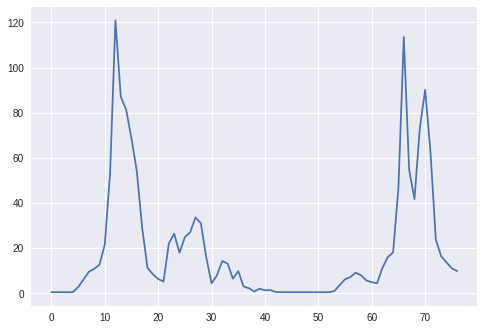

In [0]:
x = final_result[1,:,2]
plt.plot(x)